**классификатор текстов**

SnowballStemmer+TfidfVectorizer

_Евгений Борисов <esborisov@sevsu.ru>_

## тексты

In [1]:
import pandas as pd
pd.options.display.precision = 2 
pd.options.display.max_colwidth = 200 

from tqdm.notebook import tqdm
tqdm.pandas()

датасет Lenta.Ru-News

https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/

датасеты для примеров   

https://disk.yandex.ru/d/3_WAa7SgrQYBzw

In [2]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))
data.sample(2)

записей: 3196


,text,tag
3008,"В списке присутствуют как дорогие, так и массовые модели седанов.\n\nТак, четырехдверка Lincoln Continental окажется не доступной для россиян, так как её минимальная цена составляет 44 тысячи долл...",auto
740,"Глава Минска: ""Показатели по экспорту туристических и гостиничных услуг оставляют желать лучшего""\n\n8 декабря 2016 в 11:19\n\nБЕЛТА\n\nРабота коммунальных гостиниц Минска должна быть более эффект...",economics


## токенайзер со стемингом и очисткой

In [3]:
# !pip install natasha 

In [4]:
# import nltk
# nltk.download('stopwords')

In [5]:
# токенайзер Natasha

import re
from razdel import tokenize
from nltk.corpus import stopwords as nltk_stopwords
stopwords = set(nltk_stopwords.words('russian'))

def tokenizer(text,stopwords=stopwords):
    return [
            t.text for t in tokenize( # разбиваем текст на слова
                re.sub(r'</?[a-z]+>',' ',text), # удаляем xml tag 
            ) 
            if not (
               False
               or (t.text in stopwords) # выкидываем предлоги, союзы и т.п.    
               or re.match(r'^[^a-zA-ZЁёА-я]+$', t.text) # выкидываем токены не содержащие букв
               or re.match(r'^(\w)\1+$', t.text)  # выкидываем токены из одного повторяющегося символа
               or re.match(r'^[^a-zA-ZЁёА-я].*$', t.text)  # выкидываем токены начинающиеся не с буквы
            )
        ] 

In [6]:
# токенайзер cо стеммером
#
# from nltk.tokenize import word_tokenize as nltk_tokenize_word
# from nltk.stem.snowball import SnowballStemmer
# from nltk.corpus import stopwords as nltk_stopwords
# import re

# stemmer = SnowballStemmer('russian')
# stopwords = set(nltk_stopwords.words('russian'))

# def tokenizer(text,stemmer=stemmer,stopwords=stopwords):
#     return [
#             stemmer.stem(t) # выполняем стеминг
#             for t in nltk_tokenize_word( # разбиваем текст на слова
#                 re.sub(r'</?[a-z]+>',' ',text), # удаляем xml tag 
#                 language='russian'
#             ) 
#             if not (
#                (len(t)<3) # выкидываем очень короткие слова
#                or re.match(r'^[^a-zA-ZЁёА-я]+$', t) # выкидываем токены не содержащие букв
#                or re.match(r'^(\w)\1+$', t)  # выкидываем токены из одного повторяющегося символа
#                or re.match(r'^[^a-zA-ZЁёА-я].*$', t)  # выкидываем токены начинающиеся не с буквы
#                or (t in stopwords) # выкидываем предлоги, союзы и т.п.    
#             )
#         ] 
    
# # data['text'].progress_apply(tokenizer)

In [7]:
# # токенайзер с лемматизацией

# from natasha import Doc
# from natasha import Segmenter
# from natasha import MorphVocab
# from natasha import NewsEmbedding
# from natasha import NewsMorphTagger

# from nltk.corpus import stopwords as nltk_stopwords
# stopwords = set(nltk_stopwords.words('russian'))

# seg = Segmenter() # базовый токенизатор
# # морфологический анализ
# tagger = NewsMorphTagger( NewsEmbedding() )
# lvoc = MorphVocab() # лемматизатор

# def tokenizer(text,seg=seg, tagger=tagger, lvoc=lvoc, stopwords=stopwords):
#     doc = Doc(text)
#     doc.segment(seg)
#     doc.tag_morph(tagger)
#     for t in doc.tokens: t.lemmatize(lvoc)
        
#     return [
#         t.lemma for t in doc.tokens
#         if not (
#              False
#             or (t.lemma in stopwords) # выкидываем предлоги, союзы и т.п.  
#             or re.match(r'^[^a-zA-ZЁёА-я]+$', t.lemma) # выкидываем токены не содержащие букв
#             or re.match(r'^(\w)\1+$', t.lemma)  # выкидываем токены из одного повторяющегося символа
#             or re.match(r'^[^a-zA-ZЁёА-я].*$', t.lemma)  # выкидываем токены начинающиеся не с буквы
#         )
#     ]

## выполняем частотный анализ

In [8]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

# использования токенайзера вместе с векторайзером
tf_model = TfidfVectorizer(
        min_df=.001, # выкидываем очень редкие слова
        max_df=.10, # выкидываем очень частые слова
        use_idf=False, # не используем обратную частоту
        norm='l2', # нормируем TF
        tokenizer=tokenizer, # ф-ция токенайзер
        token_pattern=None, # отключаем дефолтный токенайзер
    )

data_tf = tf_model.fit_transform( data['text'] )

CPU times: user 4.32 s, sys: 12.2 ms, total: 4.33 s
Wall time: 4.34 s


In [9]:
data_tf.shape

(3196, 19991)

In [10]:
vcb1 = sorted(tf_model.vocabulary_)
print(len(vcb1))
pd.Series(vcb1).sample(30)

19991


12396      поражением
4336         дорожных
18604     учитывались
16970           столб
19085         хорошая
8598          надеюсь
8483          мусором
5201          запуска
2436      вооруженные
2753            выдал
1365          близком
2421        волокнами
13734        проехать
17990          убитый
1190      безработицы
18201         указать
13958      протяжении
14988             род
9871          обычных
10749       отработал
15762              ск
8178          мировом
9665      образование
4533     еврокомиссия
8373           москве
9448            ночью
15289         санузел
14520    распоряжение
3636             даче
19819          эфиров
dtype: object

## формируем датасеты

In [11]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [12]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( data_tf, y, test_size=0.3, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 19991), (2237,), (959, 19991), (959,))

## обучаем классификатор

In [14]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19).fit(X_train,y_train)

## тестируем

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [16]:
# доля правильных ответов на учебном наборе
o = clf.predict(X_train)
accuracy_score(y_train,o)

0.9991059454626732

In [17]:
# доля правильных ответов на тестовом наборе
o = clf.predict(X_test)

accuracy_score(y_test,o)

0.872784150156413

In [18]:
print( classification_report( y_test, o, target_names=sorted(labels.keys()) ) )

              precision    recall  f1-score   support

        auto       0.95      0.86      0.90        87
     culture       0.78      0.93      0.85       101
   economics       0.81      0.84      0.83        76
      health       0.81      0.71      0.76        31
    incident       0.91      0.93      0.92       123
    politics       0.89      0.94      0.92       177
      realty       0.88      0.71      0.79        21
     reclama       1.00      0.71      0.83        17
     science       0.88      1.00      0.94        68
      social       0.56      0.32      0.41        44
       sport       0.98      0.98      0.98       118
        tech       0.82      0.78      0.80        89
       woman       0.86      0.86      0.86         7

    accuracy                           0.87       959
   macro avg       0.86      0.81      0.83       959
weighted avg       0.87      0.87      0.87       959



| точность (precision) | полнота (recall) |
| :---: | :---: |
| $\frac{TP}{TP + FP}$ |  $\frac{TP}{TP + FN}$ |
| найдено позитивных / всего найдено |  найдено позитивных / всего позитивных |

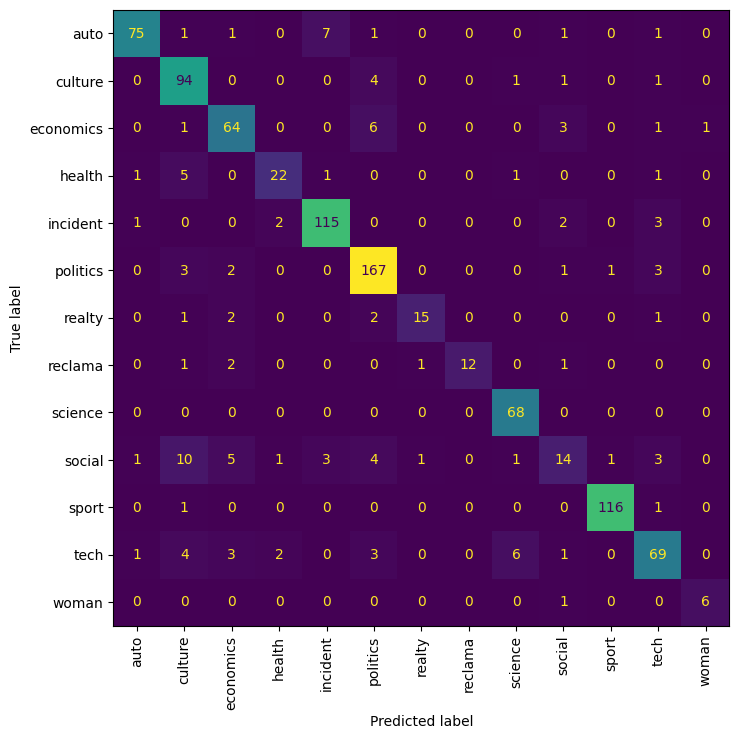

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test,o), 
    display_labels=sorted(labels.keys()),
)
disp.plot(ax=ax, xticks_rotation='vertical', include_values=True, cmap='viridis',  colorbar=False,)
plt.show()

---

In [20]:
data['predict'] = pd.Series( clf.predict(data_tf) ).map( { labels[k]:k for k in labels } )

In [23]:
data.query('tag!=predict')

,text,tag,predict
0,"В Саудовской Аравии сняли первый антитеррористический мультфильм -\nтрехминутную ленту ""Внимание!"". ""Внимание!"" отражает точку зрения мирового\nсообщества на войну, развязанную терроризмом, и поэт...",politics,culture
39,"Баскетбол : Кириленко опроверг прогнозы врачей Главная звезда российского\nбаскетбола Андрей Кириленко вернулся в строй после двухнедельного\nотсутствия, связанного с травмой правой лодыжки. О том...",sport,tech
56,"Боль в груди? А ты поди - роди! Поэтому мы решили помочь мамам восстановиться\nсамим и научиться ухаживать за новорожденным.Роддома отличаются очень\nжесткими кроватями, которые ""удваивают"" ощущения.",health,culture
79,Вышла финальная версия Firefox 1.5 Анонсирован выход релиза Firefox 1.5,tech,culture
86,"Устанавливаем Solaris 10 в VMware Workstation 5.5В PDF документе "" How\nto Install Solaris 10 Inside VMware Workstation 5.5 "" (размер 500Кб) по\nшагам и со скриншотами описан процесс конфигурирова...",tech,health
...,...,...,...
3157,28.07.2010. ИТАР-ТАСС - Программа ВОСТОК На Колыме успешно завершился\nэтнокультурный образовательныйэксперимент по программе поддержки северных\nнародов Губернские ведомости (Южно-Сахалинск) Севе...,social,culture
3158,"Центр рыночной информации АПК Закон об охоте, учитывающий интересы коренных\nмалочисленных народов Севера, вступит в силу с 1 января 2011 года Проект\nфедерального закона ""О внесении изменений в Ф...",social,politics
3169,"22.07.2010. Телекомпания ""Северный город"" Закон об охоте, учитывающий\nинтересы КМНС, вступит в силу с 1 январябудущего года. URA.RU - Российское\nинформационное агентство Задание Комаровой выпол...",politics,economics
3173,"Все новости Красноярска (Yarsk.Ru) Финансирование программы ?Коренные\nмалочисленные народы Севера? увеличится на 7 миллионов рублей 15 июля\nсостоялось заседание Правительства Красноярского края,...",economics,politics


In [22]:
# Введение в анализ текстовой информации с помощью Python и методов машинного обучения
# https://habr.com/ru/post/205360/